<a href="https://colab.research.google.com/github/Colley-K/eda_projects/blob/master/Male_vs_Female_Climbing_Grades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are Males or Females Climbing Harder Rock Climbing Grades?

## Background 
In the sport of rock climbing, males have traditionally been the ones to push the sport to higher grades. However, as of late, females have been pushing the boundaries of possible rock climbs. In this analysis, I will take a current log of 4 million rock climbs and compare the average of female rock climbing grades to that of males. Using a hypothesis test, I will test whether or not these averages are stastically the same, or if they are in fact different.

## Data
Imported from Kaggle, the 8a.nu climbing data set contains 4 tables, and is filled with 4 million entries of different rock climbs from its' users. All entries are user recorded, and prone to user error or exageration so this analysis must be taken with a little skepticism. I will clean the data to try to filter out some of the outstandingly obvious falsified entries.

## Importing from Kaggle
Using the Kaggle API, this dataset was downloaded as an SQLite database, transformed into a Pandas dataframe, and then exported as a CSV

>Click [here](https://colab.research.google.com/drive/1S4io5Nvz0lcnri_Lz9Mpa_TwLNeoSzGb#scrollTo=0BhPF3cSDvYk) to view the import notebook

>Click [here](https://www.kaggle.com/dcohen21/8anu-climbing-logbook) to view the data set on Kaggle 

_____

## Initial Setup

In [2]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area
!ls "/content/drive/My Drive" #shows whats in your drive once its mounted

#access the OS system to work with current directories:
import os 
os.getcwd() 

#Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_1samp
import math


Tue Jun 18 19:01:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import CSV Files

In [0]:
#Turn the CSV files into data frames

ascent = pd.read_csv('drive/My Drive/Capstone/ascent.csv', low_memory=False) 

user = pd.read_csv('drive/My Drive/Capstone/data/user.csv', low_memory=False) 

grade = pd.read_csv('drive/My Drive/Capstone/data/grade.csv', low_memory=False) 

## Quick EDA

In [4]:
user.head()
grade.head()
ascent.head()

,id,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,last_year,rec_date,project_ascent_date,name,crag_id,crag,sector_id,sector,country,comment,rating,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped
0,2,1,36.0,NaN,0,3,0,545,918342000,1999.0,0.0,1.107126e+09,0.0,The King And I,16596.0,Railay,61.0,Dum's kitchen,THA,Thailand\n,0.0,NaN,255.0,0.0,0.0,0.0,0.0,0.0
1,3,1,36.0,NaN,0,3,0,545,925509600,1999.0,0.0,1.107126e+09,0.0,vet ej,0.0,Nya berg - segl.,0.0,NaN,NaN,\n,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1,36.0,NaN,0,3,0,545,933026400,1999.0,0.0,1.107126e+09,0.0,Mr Big,209.0,Sjöända,371.0,Huvudväggen,SWE,\n,0.0,NaN,255.0,0.0,0.0,0.0,0.0,0.0
3,5,1,36.0,NaN,0,3,0,545,933026400,1999.0,0.0,1.107126e+09,0.0,Tak ska du ha,209.0,Sjöända,371.0,Huvudväggen,SWE,\n,0.0,NaN,255.0,0.0,0.0,0.0,0.0,0.0
4,6,1,36.0,NaN,0,3,0,545,933458400,1999.0,0.0,1.107126e+09,0.0,Korpen flyger,0.0,"Rankulla, Vetlanda",0.0,NaN,NaN,\n,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Figuring out which value is male versus female: MALE = 0, FEMALE = 1

user["sex"].value_counts()

0      53898
1       8691
255        4
Name: sex, dtype: int64

In [6]:
#Figuring out which value is a rope route versus a bouldering route: ROPE = 0, BOULDERING = 1
ascent.climb_type.value_counts()

0    2875676
1    1236202
Name: climb_type, dtype: int64

## Clean Up & Merge 3 Dataframes


*   Drop unneccesary columns in all three columns
*   Forward fill the "grade table" so all grade_is correspond to a difficulty number
* Drop any nulls
* Filter out any users that entered extreme weights or height values because their entries cannot be trusted to be valid information
* Turn all floats into integers because floats are not needed for whole numbers



In [0]:
#Trimming all three data frames to only the necessary columns

#Dropping Columns
a_cols = ["user_id", "grade_id", "climb_type"]
u_cols = ["id", "sex", "height", "weight"]
g_cols = ["id","usa_routes", "usa_boulders"]

ascent = ascent[a_cols]
user= user[u_cols]
grade = grade[g_cols]

In [0]:
#Forward filling the rock climbing grades

grade[["usa_routes", "usa_boulders"]]= grade[["usa_routes", "usa_boulders"]].fillna(method='ffill')

In [0]:
#Drop all null values
ascent= ascent.dropna(axis=0) 
user = user.dropna(axis=0)
grade = grade.dropna (axis= 0)

### Merging the 3 Dataframes

In [0]:
#Left merge the ascent table with user table
ascent = ascent.merge(user,how='left', left_on='user_id', right_on='id')

In [0]:
#Left merge the ascent table with grade table
rock = ascent.merge(grade,how='left', left_on='grade_id', right_on='id')

In [0]:
#Drop unnecessary columns
rock = rock.drop(["id_x", "id_y"], axis= 1)

In [0]:
#Cleaning up sex, weight, height columns
rock = rock[rock.sex != 255]
rock = rock[(rock.height > 134) & (rock.height < 215)] #weeding out extreme entries that are less than 4 feet 5 inches tall & taller than 7 feet
rock = rock[(rock.weight > 30)] #weeding out a person that weighs less than 70 lbs

In [0]:
#converting floats to integers
cols= ["sex", "height", "weight", "grade_id", "climb_type", "user_id"]
rock[cols] = rock[cols].astype('int64')

In [15]:
rock.head()

,user_id,grade_id,climb_type,sex,height,weight,usa_routes,usa_boulders
0,1,36,0,0,177,73,5.10a,V3
1,1,36,0,0,177,73,5.10a,V3
2,1,36,0,0,177,73,5.10a,V3
3,1,36,0,0,177,73,5.10a,V3
4,1,36,0,0,177,73,5.10a,V3


## Exporting Dataframe for Future Use


In [0]:
from google.colab import files
rock.to_csv(r'/content/drive/My Drive/Capstone/data/rock.csv', index = None, header=True)

_______
## Male vs. Female  EDA
* In this section I will separated out male versus female data
* Look at the summary stastistics of each table
* Visualize the differences between male and female grades

In [0]:
#creating two data frames for Male & Female
f_rock = rock[rock.sex == 1]
m_rock= rock[rock.sex == 0]

In [18]:
#Labelling the means
f_mu = f_rock.grade_id.mean()
m_mu= m_rock.grade_id.mean()
print (f"Female average climb difficulty: {f_mu}")
print (f"Male average climb difficulty: {m_mu}")

Female average climb difficulty: 43.64609409243656
Male average climb difficulty: 46.98894091434864


In [19]:
#female summary stastistics
f_rock.describe()

,user_id,grade_id,climb_type,sex,height,weight
count,246396.000000,246396.000000,246396.000000,246396.0,246396.000000,246396.000000
mean,30234.513718,43.646094,0.208912,1.0,164.513304,54.187426
std,17493.507404,9.214684,0.406532,0.0,7.202574,7.432530
min,4.000000,7.000000,0.000000,1.0,135.000000,40.000000
25%,16501.000000,38.000000,0.000000,1.0,160.000000,48.000000
50%,28706.000000,44.000000,0.000000,1.0,165.000000,53.000000
75%,42935.000000,51.000000,0.000000,1.0,170.000000,58.000000
max,67015.000000,75.000000,1.000000,1.0,200.000000,100.000000


In [20]:
#male summary stastistics
m_rock.describe()

,user_id,grade_id,climb_type,sex,height,weight
count,2.577157e+06,2.577157e+06,2.577157e+06,2577157.0,2.577157e+06,2.577157e+06
mean,2.556321e+04,4.698894e+01,2.992057e-01,0.0,1.778378e+02,7.001573e+01
std,1.720688e+04,9.229671e+00,4.579102e-01,0.0,7.078003e+00,8.390036e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.0,1.350000e+02,4.000000e+01
25%,1.073800e+04,4.000000e+01,0.000000e+00,0.0,1.730000e+02,6.300000e+01
50%,2.317200e+04,4.900000e+01,0.000000e+00,0.0,1.780000e+02,6.800000e+01
75%,3.797200e+04,5.300000e+01,1.000000e+00,0.0,1.820000e+02,7.300000e+01
max,6.702500e+04,8.300000e+01,1.000000e+00,0.0,2.120000e+02,1.000000e+02


In [21]:
#creating a dictionary & list for the x-ticks & reference to actual grades
climb_ratings= rock.set_index('grade_id').to_dict()['usa_routes']
print (climb_ratings)
full_ratings= ['3/4', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9','5.10a','5.10b','5.10c','5.10d','5.11a', '5.11b','5.11d','5.12a','5.12b','5.12c','5.12d','5.13a','5.13b','5.13c','5.13d','5.14a','5.14b','5.14b/c','5.14c', '5.14d', '5.15a', '5.15b', '5.15c']

{36: '5.10a', 38: '5.10b', 40: '5.10c', 42: '5.10d', 44: '5.11a', 46: '5.11b', 49: '5.11d', 51: '5.12a', 53: '5.12b', 55: '5.12c', 57: '5.12d', 62: '5.13b', 59: '5.13a', 64: '5.13c', 66: '5.13d', 72: '5.14c', 68: '5.14a', 70: '5.14b', 75: '5.14d', 31: '5.8', 33: '5.9', 21: '5.4', 29: '5.7', 13: '5.3', 1: '3/4', 71: '5.14b/c', 77: '5.15a', 73: '5.14c/d', 23: '5.5', 25: '5.6', 17: '5.3', 15: '5.3', 79: '5.15b', 7: '5.1', 83: '5.15c', 81: '5.15c'}


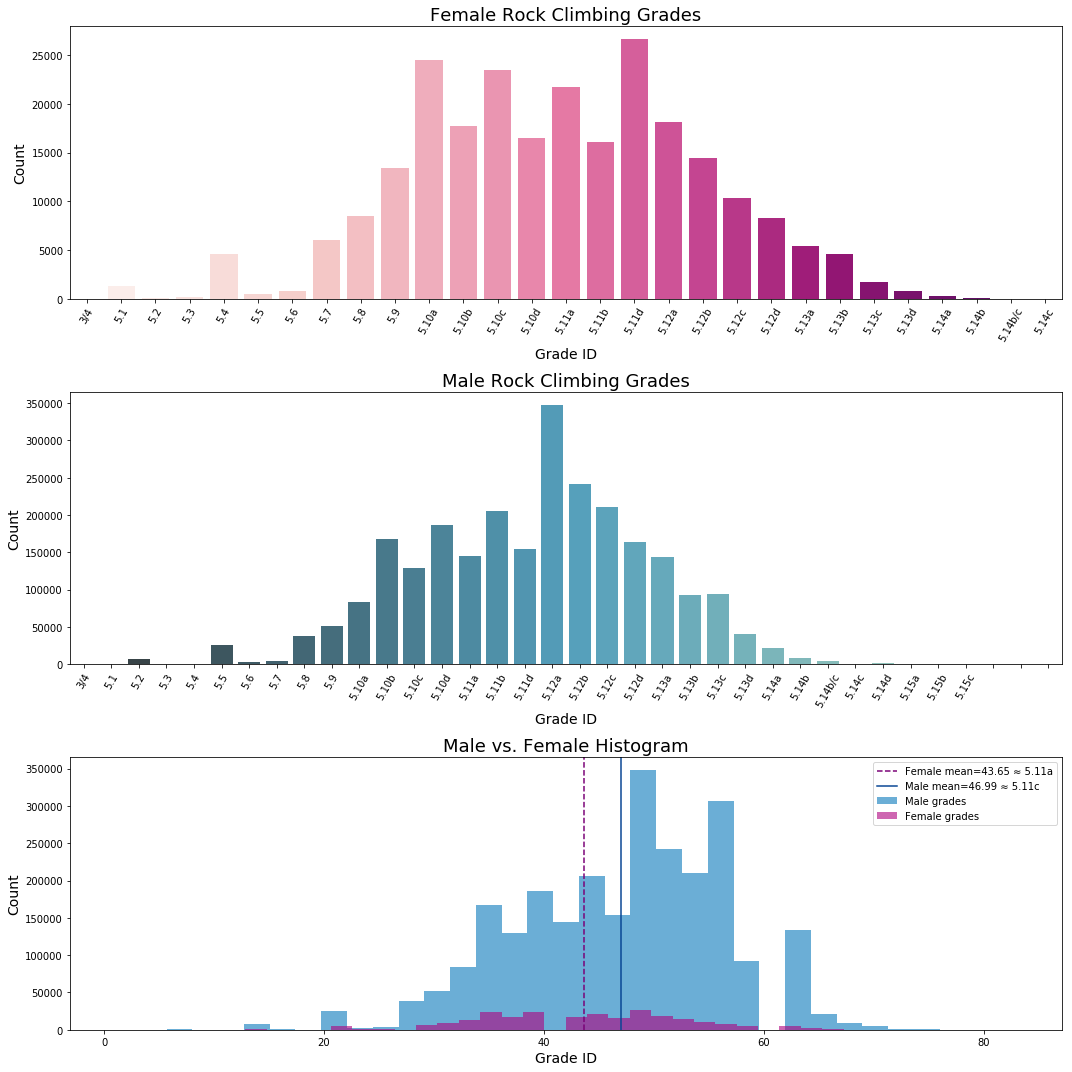

In [22]:
# Graphing Male versus Female

fig= plt.figure(figsize=(15,15))

#female 
ax1= fig.add_subplot(3,1,1)
sns.countplot(x='grade_id', data=f_rock, palette = "RdPu")
plt.xlabel("Grade ID", fontsize= 14)
plt.ylabel("Count", fontsize= 14)
plt.title("Female Rock Climbing Grades", fontsize= 18)
ax1.set_xticklabels(full_ratings, rotation=60)

#male
ax2 = plt.subplot(3,1,2)
sns.countplot(x="grade_id", data= m_rock, palette = "GnBu_d")
plt.xlabel("Grade ID", fontsize= 14)
plt.ylabel("Count", fontsize= 14)
plt.title("Male Rock Climbing Grades", fontsize= 18)
ax2.set_xticklabels(full_ratings, rotation=60)

#joint histogram
plt.subplot (3,1,3)
plt.hist(m_rock["grade_id"],bins=35, color= "#6baed6", label= "Male grades")
plt.hist(f_rock["grade_id"],bins=35, color= "#ae017e", alpha=.6, label= "Female grades")
plt.axvline(f_mu, color='#7a0177', linestyle='dashed', label=(f'Female mean={f_mu:.2f} ≈ 5.11a'))
plt.axvline(m_mu, color='#084594', label=(f'Male mean={m_mu:.2f} ≈ 5.11c'))
plt.xlabel("Grade ID", fontsize= 14)
plt.ylabel("Count", fontsize= 14)
plt.title('Male vs. Female Histogram', fontsize= 18)
plt.legend()

plt.tight_layout()

<function matplotlib.pyplot.show>

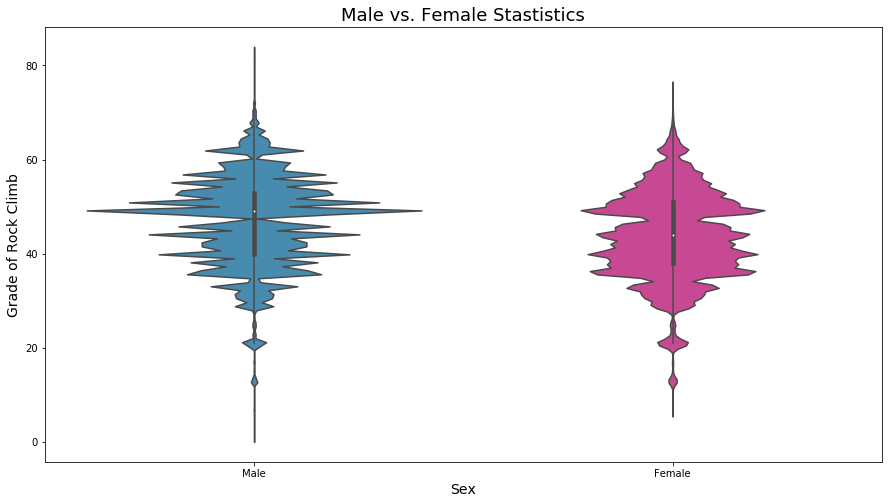

In [23]:
#Violin Plots

#Function to create a labelled sex column
def sex(x):
    if x == 1:
        return "Female"
    else:
        return "Male"

#create a new column in the data frame with sizes
rock["sex_2"]= [sex(row) for row in rock["sex"]]

#Creating a color palette
my_pal = {"Female": "#dd3497", "Male": "#3690c0"}

#Generate Plot
fig, ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="sex_2", y="grade_id", data = rock, palette=my_pal)
plt.title("Male vs. Female Stastistics", fontsize=18)
plt.xlabel("Sex", fontsize= 14)
plt.ylabel("Grade of Rock Climb", fontsize= 14)
plt.show

## Initial Impressions from EDA


*   Males have a larger range of climbing grades
* Male climbing grades have more outliers on the lower grades and a larger inner quartile range
* Male grades have a spike of climbs logged at 5.11d on rope or V6  for bouldering
*   Female climbing grades tend to be more consistent in the innerquartile with the most logged climbs ranging anywhere from 5.10a to 5.11d on rope or V3-V6 for bouldering
* Males have a higher logged a slightly higher max climb than females (5.14d versus 5.14c) even though harder grades are being climbed in the world, they were not logged here.
* *Now time to test the hypothesis that the averages are different!*

_____




# Hypothesis Test

### Process
1. State the hypothesis and significance level
2. For fun, try a T-test and a Z-test to test the hypothesis, and see if there are differing results 

### Stating the Hypothesis & Alpha:
* Null hypothesis 
>$H_0: \mu1 = \mu2 $
>*There is no difference between the average male & female climbing grades*

* Alternative hypothesis 
> $ H_1: \mu1 > \mu2 $
>*Average male climbing grades are higher than female climbing grades*

* Significance Level
> $ {\alpha = .05} $

In [24]:
#Restating the means
print (f"Female average climb difficulty: {f_mu}")
print (f"Male average climb difficulty: {m_mu}")

Female average climb difficulty: 43.64609409243656
Male average climb difficulty: 46.98894091434864


In [25]:
##computing the combined mean
combined_mean= np.mean(rock["grade_id"])
print (f"Combined mean: {combined_mean}")

#turning columns into arrays for functions
m_grade_ary = m_rock["grade_id"].values
f_grade_ary = f_rock["grade_id"].values


Combined mean: 46.697228987732835


In [26]:
#T-TEST two sample/one-tail

ttest, p = ttest_ind(m_grade_ary,f_grade_ary)

#Results
print ("T-Test Results:")
print(f"P-value:{p:.5f}")
if p <0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

T-Test Results:
P-value:0.00000
we reject null hypothesis


In [27]:
#Z-TEST two sample/one-tail 

#z-test 
ztest ,pval = stests.ztest(m_grade_ary, x2=f_grade_ary, value=0)

#results
print("Z-Test Results:")
print(f"P-value:{pval:.5f}")
if pval < 0.05:    # alpha value is 5%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")
    
# Compute mean and standard deviation of the current sample: mu, sigma
n= len(rock["grade_id"])
sd = np.std(rock["grade_id"])
z= 1.96 #critical z-value for 95% confidence interval

#Compute the 95% confidence interval
margin_er = z * (sd/math.sqrt(n))

# Print the confidence interval & margin of error
print(f"The margin of error = {margin_er}")
print(f'The 95% confidence interval = [{combined_mean- margin_er}, {combined_mean + margin_er}]')

Z-Test Results:
P-value:0.00000
We reject the null hypothesis
The margin of error = 0.010820325949267323
The 95% confidence interval = [46.68640866178357, 46.7080493136821]


## Results & Conclusions


*   The p-value is incredibly small with both the T & Z tests, and it is stasistically not probable the the difference in male & female climbing grades is due to chance 
*   Therefore, we can say that based on this dataset male climbing grades are higher than female climbing grades on average
* This would be fun project to reanalyze in the future when more females start to log harder climbs
* Also, with more time, it would be valuable to try different cleaning techniques to see what data was left out of this analysis

